# NowcastNet: 融入物理机制的生成式短临降水预报模型

## 概述

NowcastNet是由清华大学龙明盛老师团队开发的一个基于雷达数据的短临降水预报模型。 它提供了0-3h的短临降水预报结果，空间分辨率为1km左右。
该模型主要分为evolution和generation两大模块，其中evolution模块融入了物理机制，给出一个粗糙的预测结果。接着，generation模块在此
基础上生成精细化的结果，从而得到最终的降水预报。模型框架图入下图所示(图片来源于论文 [Skilful nowcasting of extreme precipitation with NowcastNet](https://www.nature.com/articles/s41586-023-06184-4))

![nowcastnet](images/nowcastnet.png)

## NowcastNet

1. Evolution network：融入物理机制，以历史的$x_{-T:0}$为输入，通过U-Net预测动量$v_{1:T}$和残差$s_{1:T}$，再经过evolution operator得到预测$x_{1:T}^{''}$。形式如下：

$$
x_{1:T}^{''} = Evolution(x_{-T:0})
$$

2. Nowcast encoder & decoder：采用[Semantic Image Synthesis with Spatially-Adaptive Normalization](https://openaccess.thecvf.com/content_CVPR_2019/papers/Park_Semantic_Image_Synthesis_With_Spatially-Adaptive_Normalization_CVPR_2019_paper.pdf)架构把Evolution network的输出$x_{1:T}^{''}$做为conditioning进行GAN训练。

## 技术路径

MindSpore Earth求解该问题的具体流程如下:

1. 创建数据集
2. 模型构建
3. 损失函数
4. 模型训练
5. 模型评估与可视化

训练和测试所用的数据集可以在: [Nowcastnet/dataset]() 下载

In [1]:
import random

import matplotlib.pyplot as plt
import mindspore as ms
import numpy as np
from mindspore import context, nn, amp, set_seed
from mindspore.train.serialization import load_checkpoint, load_param_into_net

[WARNING] ME(693605:281472989458464,MainProcess):2024-02-01-10:45:55.954.650 [mindspore/run_check/_check_version.py:348] Using custom Ascend AI software package (Ascend Data Center Solution) path, package version checking is skipped. Please make sure Ascend AI software package (Ascend Data Center Solution) version is supported. For details, refer to the installation guidelines https://www.mindspore.cn/install
[WARNING] ME(693605:281472989458464,MainProcess):2024-02-01-10:45:55.957.409 [mindspore/run_check/_check_version.py:461] Can not find the tbe operator implementation(need by mindspore-ascend). Please check whether the Environment Variable PYTHONPATH is set. For details, refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(693605:281472989458464,MainProcess):2024-02-01-10:45:55.958.132 [mindspore/run_check/_check_version.py:468] Can not find driver so(need by mindspore-ascend). Please check whether the Environment Variable LD_LIBRARY_PATH is set. For 

In [2]:
from src import get_logger
from src import EvolutionTrainer, GenerationTrainer, GenerateLoss, DiscriminatorLoss, EvolutionLoss
from src import EvolutionPredictor, GenerationPredictor
from src import RadarData, NowcastDataset
from src.evolution import EvolutionNet
from src.generator import GenerationNet
from src.discriminator import TemporalDiscriminator
from src.visual import change_alpha
from mindearth.utils.tools import load_yaml_config

In [4]:
np.random.seed(0)
set_seed(0)
random.seed(0)

In [6]:
config = load_yaml_config("./configs/Nowcastnet.yaml")
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=1)

## 创建数据集

在[dataset]()路径下，下载训练数据集，验证数据集到`./dataset`目录，修改`./configs/Nowcastnet.yaml`配置文件中的`root_dir`。

`./dataset`中的目录结构如下所示：

```markdown
├── train
├── valid
├── test
```

## Evolution

In [8]:
logger = get_logger(config)
config["model"]["module_name"] = 'evolution'
config["data"]["batch_size"] = 4
config["summary"]["eval_interval"] = 1
config["summary"]["visual"] = False
train_params = config.get("train")
summary_params = config.get("summary")
evo_model = EvolutionNet(config)
evo_model.set_train()

2024-02-01 10:47:26,275 - utils.py[line:55] - INFO: {'name': 'NowcastNet', 'ngf': 32, 'pool_ensemble_num': 4, 'module_name': 'evolution'}
2024-02-01 10:47:26,276 - utils.py[line:55] - INFO: {'name': 'us', 'root_dir': '/data/zmmVol1/cszhou/usa_datasets', 't_in': 9, 't_out': 20, 'h_size': 512, 'w_size': 512, 'time_interval': 10, 'num_workers': 1, 'data_sink': False, 'batch_size': 1, 'noise_scale': 32}
2024-02-01 10:47:26,277 - utils.py[line:55] - INFO: {'name': 'adam', 'beta1': 0.01, 'beta2': 0.9, 'g_lr': 1.5e-05, 'd_lr': '6e-5', 'epochs': 10}
2024-02-01 10:47:26,278 - utils.py[line:55] - INFO: {'name': 'adam', 'lr': 0.001, 'weight_decay': 0.1, 'gamma': 0.5, 'epochs': 50}
2024-02-01 10:47:26,279 - utils.py[line:55] - INFO: {'summary_dir': './summary/', 'eval_interval': 2, 'save_checkpoint_epochs': 1, 'keep_checkpoint_max': 4, 'key_info_timestep': [10, 60, 120], 'generate_ckpt_path': '/data/zmmVol1/cszhou/nowcastnet_final/applications/nowcasting/Nowcastnet/ckpt/generator-device13.ckpt', '

EvolutionNet<
  (evo_net): EvolutionNetwork<
    (inc): DoubleConv<
      (single_conv): SequentialCell<
        (0): BatchNorm2d<num_features=9, eps=1e-05, momentum=0.9, gamma=Parameter (name=evo_net.inc.single_conv.0.gamma, shape=(9,), dtype=Float32, requires_grad=True), beta=Parameter (name=evo_net.inc.single_conv.0.beta, shape=(9,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=evo_net.inc.single_conv.0.moving_mean, shape=(9,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=evo_net.inc.single_conv.0.moving_variance, shape=(9,), dtype=Float32, requires_grad=False)>
        (1): SpectralNormal<
          (parametrizations): Conv2d<input_channels=9, output_channels=32, kernel_size=(3, 3), stride=(1, 1), pad_mode=pad, padding=1, dilation=(1, 1), group=1, has_bias=True, weight_init=<mindspore.common.initializer.HeUniform object at 0xfffedc994520>, bias_init=<mindspore.common.initializer.Uniform object at 0xfffedc994700>, format=NCHW>
          >
 

### 模型训练

In [8]:
# loss_scale = ms.amp.DynamicLossScaleManager(init_loss_scale=2 ** 18, scale_factor=2, scale_window=1000)
loss_scale = ms.train.loss_scale_manager.FixedLossScaleManager(loss_scale=2048)
evo_loss_fn = EvolutionLoss(evo_model, config)
trainer = EvolutionTrainer(config, evo_model, evo_loss_fn, logger, loss_scale)
trainer.train()

[WARNING] MD(4138269,fffcfb65b120,python):2024-01-31-09:02:51.669.590 [mindspore/ccsrc/minddata/dataset/engine/datasetops/source/generator_op.cc:231] operator()] Bad performance attention, it takes more than 25 seconds to generator.__next__ new row, which might cause `GetNext` timeout problem when sink_mode=True. You can increase the parameter num_parallel_workers in GeneratorDataset / optimize the efficiency of obtaining samples in the user-defined generator function.


epoch: 1 step: 1, loss is 16.964931
epoch: 1 step: 2, loss is 14.502213
epoch: 1 step: 3, loss is 10.780349
epoch: 1 step: 4, loss is 11.027175
epoch: 1 step: 5, loss is 3.8108711
epoch: 1 step: 6, loss is 13.924669
epoch: 1 step: 7, loss is 12.181091
epoch: 1 step: 8, loss is 4.613654
epoch: 1 step: 9, loss is 4.306578
epoch: 1 step: 10, loss is 4.932178
epoch: 1 step: 11, loss is 6.628277
epoch: 1 step: 12, loss is 3.5065076
epoch: 1 step: 13, loss is 20.65365
epoch: 1 step: 14, loss is 17.443842
epoch: 1 step: 15, loss is 7.5954895
epoch: 1 step: 16, loss is 7.138162
epoch: 1 step: 17, loss is 6.9041977
epoch: 1 step: 18, loss is 19.990036
epoch: 1 step: 19, loss is 9.513996
epoch: 1 step: 20, loss is 7.3165126
epoch: 1 step: 21, loss is 6.1689415
epoch: 1 step: 22, loss is 6.158663
epoch: 1 step: 23, loss is 9.237205
epoch: 1 step: 24, loss is 7.669189
epoch: 1 step: 25, loss is 5.0312796
epoch: 1 step: 26, loss is 6.590024
epoch: 1 step: 27, loss is 15.463813
epoch: 1 step: 28, lo

2024-01-31 09:32:00,659 - forecast.py[line:191] - INFO: ================================Start Evaluation================================
2024-01-31 09:32:00,661 - forecast.py[line:192] - INFO: The length of data is: 1


2024-01-31 09:32:04,107 - forecast.py[line:179] - INFO: CSI Neighborhood threshold 16 T+10 min: 0.4054458796087876 T+60 min: 0.16474475307855177 T+120 min: 0.09442198339292594
2024-01-31 09:32:04,181 - forecast.py[line:211] - INFO: ================================End Evaluation================================


epoch: 2 step: 1, loss is 3.5902307
epoch: 2 step: 2, loss is 6.164537
epoch: 2 step: 3, loss is 11.180219
epoch: 2 step: 4, loss is 11.332051
epoch: 2 step: 5, loss is 4.4809947
epoch: 2 step: 6, loss is 6.9257097
epoch: 2 step: 7, loss is 7.415494
epoch: 2 step: 8, loss is 11.204009
epoch: 2 step: 9, loss is 8.37794
epoch: 2 step: 10, loss is 9.490828
epoch: 2 step: 11, loss is 2.3988461
epoch: 2 step: 12, loss is 6.1954045
epoch: 2 step: 13, loss is 12.88989
epoch: 2 step: 14, loss is 14.573158
epoch: 2 step: 15, loss is 6.751909
epoch: 2 step: 16, loss is 6.6825066
epoch: 2 step: 17, loss is 8.922988
epoch: 2 step: 18, loss is 10.171614
epoch: 2 step: 19, loss is 21.820257
epoch: 2 step: 20, loss is 8.730773
epoch: 2 step: 21, loss is 11.956616
epoch: 2 step: 22, loss is 12.381399
epoch: 2 step: 23, loss is 6.375179
epoch: 2 step: 24, loss is 6.8310676
epoch: 2 step: 25, loss is 9.096922
epoch: 2 step: 26, loss is 8.052887
epoch: 2 step: 27, loss is 10.0189085
epoch: 2 step: 28, lo

2024-01-31 10:00:12,836 - forecast.py[line:191] - INFO: ================================Start Evaluation================================
2024-01-31 10:00:12,838 - forecast.py[line:192] - INFO: The length of data is: 1


2024-01-31 10:00:16,213 - forecast.py[line:179] - INFO: CSI Neighborhood threshold 16 T+10 min: 0.41709989523909563 T+60 min: 0.16894114336218546 T+120 min: 0.10467792846088278
2024-01-31 10:00:16,291 - forecast.py[line:211] - INFO: ================================End Evaluation================================


epoch: 3 step: 1, loss is 7.1252494
epoch: 3 step: 2, loss is 11.036712
epoch: 3 step: 3, loss is 5.4519153
epoch: 3 step: 4, loss is 5.8808107
epoch: 3 step: 5, loss is 4.4894466
epoch: 3 step: 6, loss is 4.2037396
epoch: 3 step: 7, loss is 7.131599
epoch: 3 step: 8, loss is 7.6371865
epoch: 3 step: 9, loss is 10.900062
epoch: 3 step: 10, loss is 6.7450824
epoch: 3 step: 11, loss is 8.569858
epoch: 3 step: 12, loss is 12.626097
epoch: 3 step: 13, loss is 16.801985
epoch: 3 step: 14, loss is 12.869039
epoch: 3 step: 15, loss is 12.314567
epoch: 3 step: 16, loss is 10.593638
epoch: 3 step: 17, loss is 7.0162005
epoch: 3 step: 18, loss is 14.256413
epoch: 3 step: 19, loss is 6.391328
epoch: 3 step: 20, loss is 6.419895
epoch: 3 step: 21, loss is 12.473334
epoch: 3 step: 22, loss is 10.50286
epoch: 3 step: 23, loss is 6.199636
epoch: 3 step: 24, loss is 12.170155
epoch: 3 step: 25, loss is 10.767848
epoch: 3 step: 26, loss is 3.7217011
epoch: 3 step: 27, loss is 7.41636
epoch: 3 step: 28,

2024-01-31 10:28:27,000 - forecast.py[line:191] - INFO: ================================Start Evaluation================================
2024-01-31 10:28:27,002 - forecast.py[line:192] - INFO: The length of data is: 1


2024-01-31 10:28:30,512 - forecast.py[line:179] - INFO: CSI Neighborhood threshold 16 T+10 min: 0.3993438740760541 T+60 min: 0.16725303802177002 T+120 min: 0.0959103616970071
2024-01-31 10:28:30,583 - forecast.py[line:211] - INFO: ================================End Evaluation================================


epoch: 4 step: 1, loss is 3.676213
epoch: 4 step: 2, loss is 6.1458254
epoch: 4 step: 3, loss is 3.8185475
epoch: 4 step: 4, loss is 6.627117
epoch: 4 step: 5, loss is 6.9782486
epoch: 4 step: 6, loss is 6.811868
epoch: 4 step: 7, loss is 6.6884317
epoch: 4 step: 8, loss is 7.3477755
epoch: 4 step: 9, loss is 5.200476
epoch: 4 step: 10, loss is 12.155771
epoch: 4 step: 11, loss is 11.58068
epoch: 4 step: 12, loss is 5.4448733
epoch: 4 step: 13, loss is 10.812689
epoch: 4 step: 14, loss is 12.388344
epoch: 4 step: 15, loss is 5.3166175
epoch: 4 step: 16, loss is 7.333459
epoch: 4 step: 17, loss is 9.206997
epoch: 4 step: 18, loss is 3.0782144
epoch: 4 step: 19, loss is 5.3736815
epoch: 4 step: 20, loss is 12.703902
epoch: 4 step: 21, loss is 11.112024
epoch: 4 step: 22, loss is 9.309543
epoch: 4 step: 23, loss is 16.022741
epoch: 4 step: 24, loss is 14.004642
epoch: 4 step: 25, loss is 7.8977027
epoch: 4 step: 26, loss is 2.6011
epoch: 4 step: 27, loss is 4.357134
epoch: 4 step: 28, los

2024-01-31 10:56:38,214 - forecast.py[line:191] - INFO: ================================Start Evaluation================================
2024-01-31 10:56:38,216 - forecast.py[line:192] - INFO: The length of data is: 1


2024-01-31 10:56:41,586 - forecast.py[line:179] - INFO: CSI Neighborhood threshold 16 T+10 min: 0.4119070738020246 T+60 min: 0.16328413060990918 T+120 min: 0.10628156308461514
2024-01-31 10:56:41,656 - forecast.py[line:211] - INFO: ================================End Evaluation================================


epoch: 5 step: 1, loss is 10.631495
epoch: 5 step: 2, loss is 8.387822
epoch: 5 step: 3, loss is 13.710869
epoch: 5 step: 4, loss is 5.4953156
epoch: 5 step: 5, loss is 9.979673
epoch: 5 step: 6, loss is 6.714036
epoch: 5 step: 7, loss is 6.685842
epoch: 5 step: 8, loss is 4.2601423
epoch: 5 step: 9, loss is 2.9999993
epoch: 5 step: 10, loss is 2.5337834
epoch: 5 step: 11, loss is 8.508463
epoch: 5 step: 12, loss is 8.42295
epoch: 5 step: 13, loss is 8.569485
epoch: 5 step: 14, loss is 5.3934393
epoch: 5 step: 15, loss is 7.9034486
epoch: 5 step: 16, loss is 12.259567
epoch: 5 step: 17, loss is 8.008107
epoch: 5 step: 18, loss is 7.291337
epoch: 5 step: 19, loss is 4.7586455
epoch: 5 step: 20, loss is 14.302854
epoch: 5 step: 21, loss is 3.7846584
epoch: 5 step: 22, loss is 12.408534
epoch: 5 step: 23, loss is 14.33615
epoch: 5 step: 24, loss is 5.025287
epoch: 5 step: 25, loss is 8.458199
epoch: 5 step: 26, loss is 15.693871
epoch: 5 step: 27, loss is 22.327187
epoch: 5 step: 28, loss

2024-01-31 11:24:52,789 - forecast.py[line:191] - INFO: ================================Start Evaluation================================
2024-01-31 11:24:52,790 - forecast.py[line:192] - INFO: The length of data is: 1


2024-01-31 11:24:56,256 - forecast.py[line:179] - INFO: CSI Neighborhood threshold 16 T+10 min: 0.4118216017414204 T+60 min: 0.15679251293172677 T+120 min: 0.10144497020636714
2024-01-31 11:24:56,322 - forecast.py[line:211] - INFO: ================================End Evaluation================================


### evolution评估和可视化

完成训练后，我们使用ckpt进行推理，下述展示了推理的可视化图片


In [9]:
config["data"]["batch_size"] = 1
config["summary"]["visual"] = True
params = load_checkpoint('./summary/ckpt/evolution-3_200.ckpt')
evo_model.set_train(False)
load_param_into_net(evo_model, params)
evo_inference = EvolutionPredictor(config, evo_model, logger)

[WARNING] ME(693605:281472989458464,MainProcess):2024-02-01-10:47:42.791.427 [mindspore/train/serialization.py:1469] For 'load_param_into_net', remove parameter prefix name: model., continue to load.


In [10]:
def plt_img(field, label, idx, plot_evo=False, evo=None, interval=10, fig_name="", vmin=1, vmax=40, cmap="viridis"):
    if plot_evo:
        _, axs = plt.subplots(3, 3)
    else:
        _, axs = plt.subplots(2, 3)
    axs[0][0].set_axis_off()
    axs[0][1].set_axis_off()
    axs[0][2].set_axis_off()
    axs[1][0].set_axis_off()
    axs[1][1].set_axis_off()
    axs[1][2].set_axis_off()
    alpha = change_alpha(label[idx[0]])
    _ = axs[0][0].imshow(label[idx[0]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
    axs[0][0].set_title(f"label {idx[0] * interval + interval} min")
    alpha = change_alpha(label[idx[1]])
    _ = axs[0][1].imshow(label[idx[1]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
    axs[0][1].set_title(f"label {idx[1] * interval + interval} min")
    alpha = change_alpha(label[idx[2]])
    _ = axs[0][2].imshow(label[idx[2]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
    axs[0][2].set_title(f"label {idx[2] * interval + interval} min")
    alpha = change_alpha(field[idx[0]])
    _ = axs[1][0].imshow(field[idx[0]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
    axs[1][0].set_title(f"pred {idx[0] * interval + interval} min")
    alpha = change_alpha(field[idx[1]])
    _ = axs[1][1].imshow(field[idx[1]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
    axs[1][1].set_title(f"pred {idx[1] * interval + interval} min")
    alpha = change_alpha(field[idx[2]])
    _ = axs[1][2].imshow(field[idx[2]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
    axs[1][2].set_title(f"pred {idx[2] * interval + interval} min")
    if plot_evo:
        axs[2][0].set_axis_off()
        axs[2][1].set_axis_off()
        axs[2][2].set_axis_off()
        alpha = change_alpha(evo[idx[0]])
        _ = axs[2][0].imshow(evo[idx[0]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
        axs[2][0].set_title(f"evo results {idx[0] * interval + interval} min")
        alpha = change_alpha(evo[idx[1]])
        _ = axs[2][1].imshow(evo[idx[1]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
        axs[2][1].set_title(f"evo results {idx[1] * interval + interval} min")
        alpha = change_alpha(evo[idx[2]])
        _ = axs[2][2].imshow(evo[idx[2]], alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
        axs[2][2].set_title(f"evo results {idx[2] * interval + interval} min")
    plt.savefig(fig_name, dpi=180)
    plt.show()
    plt.close()

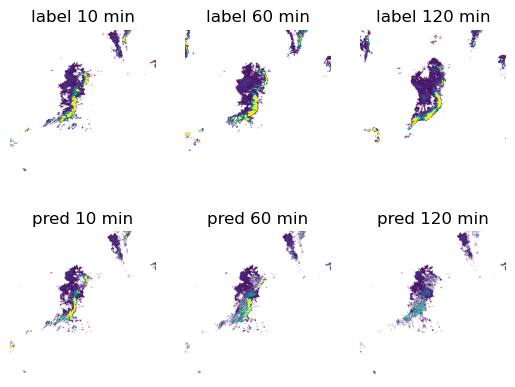

In [11]:
data_params = config.get("data")
test_dataset_generator = RadarData(data_params, run_mode='test', module_name="evolution")
test_dataset = NowcastDataset(test_dataset_generator,
                              module_name="evolution",
                              distribute=train_params.get('distribute', False),
                              num_workers=data_params.get('num_workers', 1),
                              shuffle=False)
test_dataset = test_dataset.create_dataset(data_params.get('batch_size', 1))
# data = next(test_dataset.create_dict_iterator())
steps = 1
for d in test_dataset.create_dict_iterator():
    if steps == 5:
        data = d
        break
    steps += 1
inputs = data['inputs']
pred = evo_inference.forecast(inputs)
labels = inputs[:, data_params.get("t_in"):]
plt_idx = [x // data_params.get("time_interval") - 1 for x in data_params.get("key_info_timestep", [10, 60, 120])]
plt_img(field=pred[0].asnumpy(), label=labels[0].asnumpy(), idx=plt_idx, fig_name="./evolution_example.png")

## Generation

### 模型训练

In [12]:
config["model"]["module_name"] = 'generation'
config["data"]["batch_size"] = 1
config["summary"]["visual"] = False
config["summary"]["save_checkpoint_epochs"] = 1
train_params = config.get("train")
summary_params = config.get("summary")
g_model = GenerationNet(config)
d_model = TemporalDiscriminator(data_params.get("t_in", 9) + data_params.get("t_out", 20))
g_model.set_train()
d_model.set_train()
g_model = amp.auto_mixed_precision(g_model, amp_level=train_params.get("amp_level", 'O2'))
d_model = amp.auto_mixed_precision(d_model, amp_level=train_params.get("amp_level", 'O2'))

In [ ]:
loss_scale = nn.DynamicLossScaleUpdateCell(loss_scale_value=2 ** 12, scale_factor=2, scale_window=1000)
g_loss_fn = GenerateLoss(g_model, d_model)
d_loss_fn = DiscriminatorLoss(g_model, d_model)
trainer = GenerationTrainer(config, g_model, d_model, g_loss_fn, d_loss_fn, logger, loss_scale)
trainer.train()

### generation评估和可视化

完成训练后，我们使用ckpt进行推理，下述展示了推理的可视化图片

In [15]:
config["summary"]["visual"] = True
config["summary"]["generate_ckpt_path"] = "./ckpt/generator5_5w_beta10.ckpt"
config["train"]["load_ckpt"] = True
gen_inference = GenerationPredictor(config, g_model, logger)

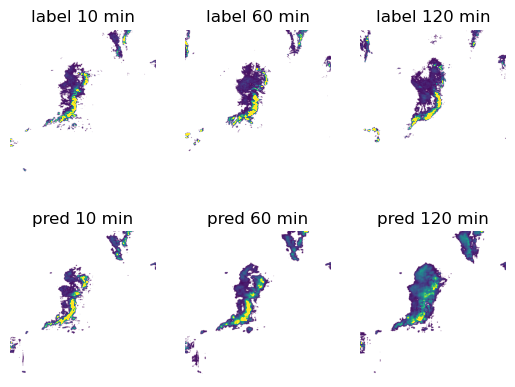

In [16]:
data_params = config.get("data")
model_params = config.get("model")
test_dataset_generator = RadarData(data_params, run_mode='test', module_name="generation")
test_dataset = NowcastDataset(test_dataset_generator,
                              module_name="generation",
                              distribute=train_params.get('distribute', False),
                              num_workers=data_params.get('num_workers', 1),
                              shuffle=False)
test_dataset = test_dataset.create_dataset(data_params.get('batch_size', 1))
# data = next(test_dataset.create_dict_iterator())
steps = 1
for d in test_dataset.create_dict_iterator():
    if steps == 5:
        data = d
        break
    steps += 1
inp, evo_result, labels = data.get("inputs"), data.get("evo"), data.get("labels")
noise_scale = data_params.get("noise_scale", 32)
threshold = summary_params.get("csin_threshold", 16)
batch_size = data_params.get("batch_size", 1)
w_size = data_params.get("w_size", 512)
h_size = data_params.get("h_size", 512)
ngf = model_params.get("ngf", 32)
noise = ms.tensor(ms.numpy.randn((batch_size, ngf, h_size // noise_scale, w_size // noise_scale)), inp.dtype)
pred = gen_inference.generator(inp, evo_result, noise)
plt_img(field=pred[0].asnumpy(), label=labels[0].asnumpy(), idx=plt_idx, fig_name="./generation_example.png")